In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline 
import numpy as np 
import cv2
import csv
import matplotlib.pyplot as plt 
import random 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
from os import listdir
from os.path import isfile, join
Covid_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Covid/train") if f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Covid/train", f))]
Covid_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Covid/test") if f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Covid/test", f))]
Normal_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Normal/train") if  f.startswith('.') == False ]
Normal_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Normal/test") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Normal/test", f))]
Pneumonia_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Pneumonia/train") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Pneumonia/train", f))]
Pneumonia_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Pneumonia/test") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Pneumonia/test", f))]

In [ ]:
len(Normal_train_files)

180

In [ ]:
def read_data(file_names_list, data_list, labels_list, path, label):
  for i in range(len(file_names_list)):
    img = cv2.imread(path + file_names_list[i])
    img = cv2.resize(img,(224,224))
    data_list.append(img)
    labels_list.append(label)
  return data_list, labels_list

In [ ]:
train_list = []
test_list = []
train_labels = []
test_labels = []

path = "/content/drive/My Drive/Colab Notebooks/Covid/train/"
label = 0
train_list, train_labels = read_data(Covid_train_files, train_list, train_labels, path, label)
print(len(train_list),len(train_labels))
path = "/content/drive/My Drive/Colab Notebooks/Normal/train/"
label = 1
train_list, train_labels = read_data(Normal_train_files, train_list, train_labels, path, label)
print(len(train_list),len(train_labels))
path = "/content/drive/My Drive/Colab Notebooks/Pneumonia/train/"
label = 2
train_list, train_labels = read_data(Pneumonia_train_files, train_list, train_labels, path, label)
print(len(train_list),len(train_labels))
path = "/content/drive/My Drive/Colab Notebooks/Covid/test/"
label = 0
test_list, test_labels = read_data(Covid_test_files, test_list, test_labels, path, label)
print(len(test_list),len(test_labels))
path = "/content/drive/My Drive/Colab Notebooks/Normal/test/"
label = 1
test_list, test_labels = read_data(Normal_test_files, test_list, test_labels, path, label)
print(len(test_list),len(test_labels))
path = "/content/drive/My Drive/Colab Notebooks/Pneumonia/test/"
label = 2
test_list, test_labels = read_data(Pneumonia_test_files, test_list, test_labels, path, label)
print(len(test_list),len(test_labels))

179 179
359 359
539 539
30 30
60 60
90 90


In [ ]:
k = 10
folds = list(StratifiedKFold(n_splits = k, shuffle=True, random_state=1).split(train_list, train_labels))

In [ ]:
def one_hot(l):
    for i in range(len(l)):
        if(l[i] == 0):
            l[i] = [1,0,0]
        if(l[i] == 1):
            l[i] = [0,1,0]
        if(l[i] == 2):
            l[i] = [0,0,1]
    return l

In [ ]:
train_labels = one_hot(train_labels)
test_labels = one_hot(test_labels)

In [ ]:
train_list = np.array(train_list)
train_labels = np.array(train_labels)
test_list = np.array(test_list)
test_labels = np.array(test_labels)

In [ ]:
def MODEL_get():
    K.set_learning_phase(1)
    ModelX = DenseNet121(weights="imagenet", include_top=False,
                      input_tensor=Input(shape=(224, 224, 3)))
    ModelX_out = ModelX.layers[-1].output
    ModelX_out = GlobalAveragePooling2D()(ModelX_out)
    ModelX_out = Dense(256, activation = "relu", name="dense_one")(ModelX_out)
    ModelX_out = Dropout(0.3, name="dropout_add1")(ModelX_out)
    ModelX_out = Dense(512, activation = "relu", name="dense_two")(ModelX_out)
    ModelX_out = Dropout(0.5, name="dropout_add2")(ModelX_out)
    ModelX_out = Dense(3, activation="softmax", name="dense_out")(ModelX_out)
    ModelDN = Model(ModelX.input, ModelX_out)
    #for layer in ModelX.layers:
      #if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
          #layer.trainable = True
          #K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
          #K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    #else:
        #layer.trainable = False
    for layer in ModelX.layers:
      layer.trainable = False

    
    opt = SGD(lr=0.01, decay=0.01 / 30)
    ModelDN.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    
    return(ModelDN)

In [ ]:
model = DenseNet_get()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
trainAug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience =  5)
checkpoint_callback = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Covid_19_DenseNet121_best_fold.h5"+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
len(train_list)

539

In [ ]:
models_each_folds = []
models_evaluations = []
HXs = []

for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_app = train_list[train_idx]
    Y_train_app = train_labels[train_idx]
    VALX = train_list[val_idx]
    VALY= train_labels[val_idx]
    
    print("[INFO] training head...")
    
    modelX = DenseNet_get()
    
    HX = modelX.fit_generator(
    trainAug.flow(X_train_app,Y_train_app, batch_size=8),
    steps_per_epoch=len(X_train_app) // 8,
    validation_data=(VALX, VALY),
    validation_steps=len(VALX) // 8,
    callbacks=[early_stopping_callback, checkpoint_callback],
    epochs=30)
    
    K.set_learning_phase(0)
    predIdxsX = modelX.predict(test_list.astype('float16'), batch_size=8)
    predIdxsX = np.argmax(predIdxsX, axis=1)
    print(classification_report(test_labels.argmax(axis=1), predIdxsX,target_names=["COVID-19","NORMAL","PNEUMONIA"]))
    
    models_each_folds.append(modelX)
    HXs.append(HX)
    
    Loss, Acc = modelX.evaluate(test_list,test_labels)
    models_evaluations.append([Loss, Acc])
    print("(Loss, Acc):",modelX.evaluate(test_list,test_labels))
  


Fold  0
[INFO] training head...
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.7002
Epoch 00001: val_loss improved from inf to 0.82587, saving model to /content/drive/My Drive/Colab Notebooks/Covid_19_DenseNet121_best_fold.h5.h5
60/60 [==============================] - 14s 234ms/step - loss: 0.6583 - accuracy: 0.7002 - val_loss: 0.8259 - val_accuracy: 0.6481
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.8438
Epoch 00002: val_loss improved from 0.82587 to 0.39531, saving model to /content/drive/My Drive/Colab Notebooks/Covid_19_DenseNet121_best_fold.h5.h5
60/60 [==============================] - 8s 138ms/step - loss: 0.4028 - accuracy: 0.8438 - val_loss: 0.3953 - val_accuracy: 0.8333
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.9250
Epoch 00003: val_loss did not improve from 0.39531
60/60 [==============================] - 7s 124ms/step - loss: 0.2499 - accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    COVID-19       0.78      0.83      0.81        30
      NORMAL       0.00      0.00      0.00        30
   PNEUMONIA       0.52      1.00      0.68        30

    accuracy                           0.61        90
   macro avg       0.43      0.61      0.50        90
weighted avg       0.43      0.61      0.50        90

3/3 [==============================] - 0s 55ms/step - loss: 2.3947 - accuracy: 0.6111
(Loss, Acc): [2.3946878910064697, 0.6111111044883728]

Fold  7
[INFO] training head...
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.7175 - accuracy: 0.6834
Epoch 00001: val_loss did not improve from 0.00367
60/60 [==============================] - 9s 148ms/step - loss: 0.7175 - accuracy: 0.6834 - val_loss: 0.5102 - val_accuracy: 0.8333
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8700
Epoch 00002: val_loss did not improve from 0.00367
60/60 [==================

In [ ]:
test_acc = []
train_acc = []
val_acc = []

for i in range(10):
  H = HXs[i]
  train_acc.append(np.mean(HXs[i].history["accuracy"]))
  val_acc.append(np.mean(HXs[i].history["val_accuracy"]))
  test_acc.append(models_evaluations[i][1])

test_acc_mean = np.mean(test_acc)
train_acc_mean = np.mean(train_acc)
val_acc_mean = np.mean(val_acc)
print(" train accuracy mean:",train_acc_mean,"\n",
      "validation accuracy mean:",val_acc_mean,"\n",
      "test accuracy mean:",test_acc_mean)

 train accuracy mean: 0.9243752146834693 
 validation accuracy mean: 0.9162197955229081 
 test accuracy mean: 0.7300000071525574


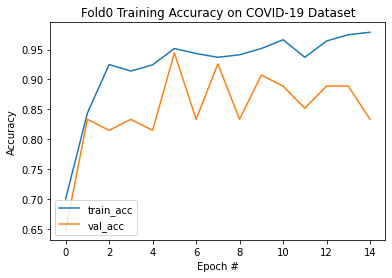

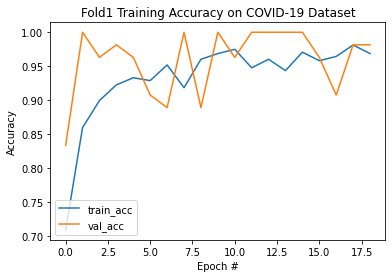

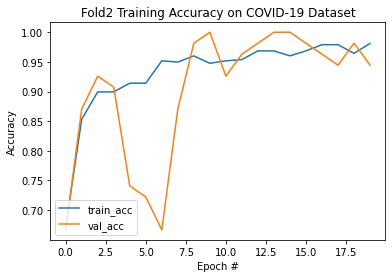

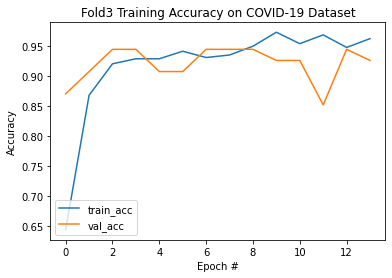

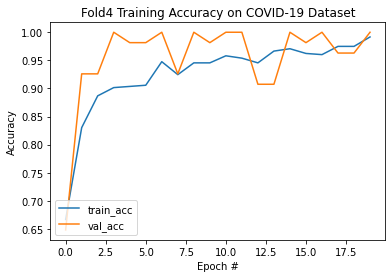

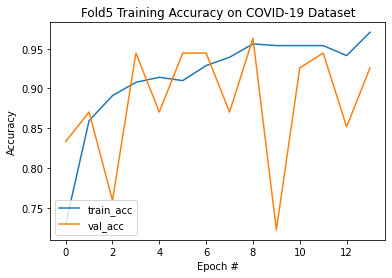

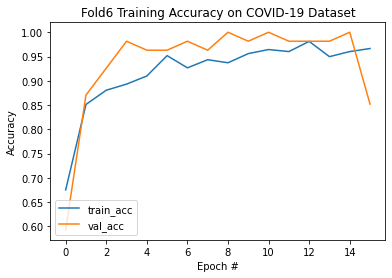

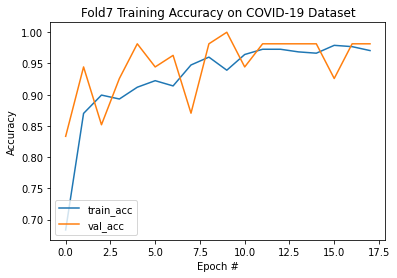

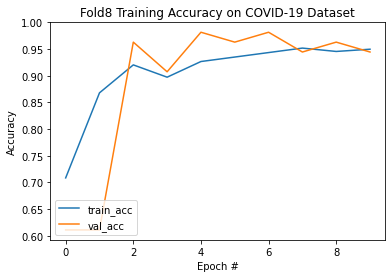

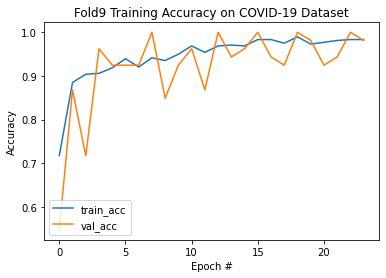

In [ ]:
for i in range(len(HXs)):
  H = HXs[i]
  N = len(H.history["accuracy"])
  plt.figure()
  plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
  plt.title("Fold"+ str(i)+" Training Accuracy on COVID-19 Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower left")
  plt.savefig("Fold_"+ str(i)+'DenseNet121_Training_Accuracy.png', bbox_inches='tight')

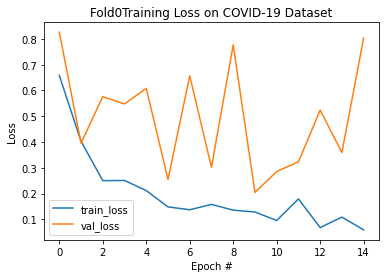

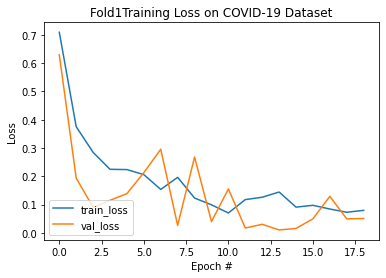

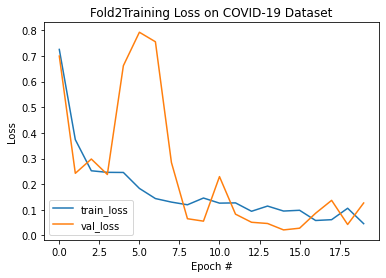

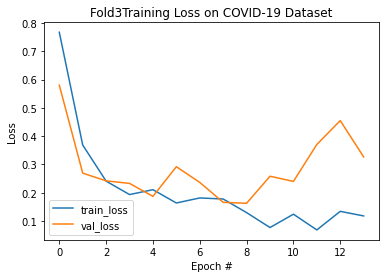

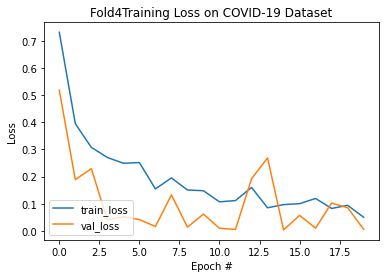

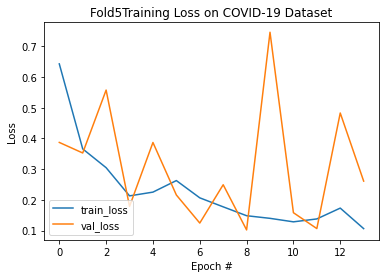

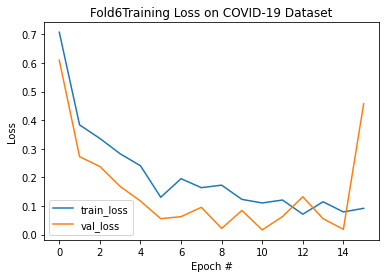

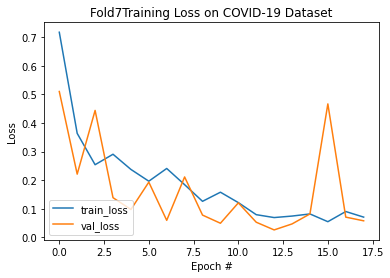

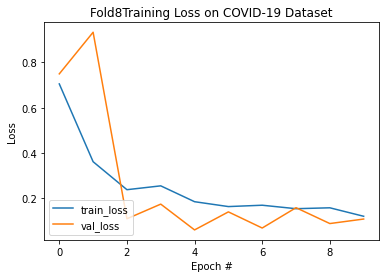

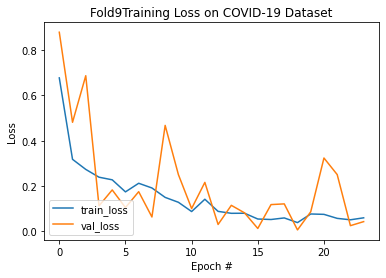

In [ ]:
for i in range(len(HXs)):
  H = HXs[i]
  N = len(H.history["accuracy"])
  plt.figure()
  plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
  plt.title("Fold"+ str(i)+"Training Loss on COVID-19 Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  plt.savefig('/content/drive/My Drive/Colab Notebooks/Covid_19_DenseNet121/Fold_'+ str(i)+'DenseNet121_Training_Loss.png', bbox_inches='tight')

In [ ]:
modelX = DenseNet_get()

HX = modelX.fit_generator(
    trainAug.flow(train_list, train_labels, batch_size=15),
    steps_per_epoch=len(train_list) // 15,
    validation_data=(test_list, test_labels),
    validation_steps=len(test_list) // 15,
    callbacks=[early_stopping_callback, checkpoint_callback],
    epochs=30)

Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 0.7629 - accuracy: 0.6622
Epoch 00001: val_loss improved from 1.09863 to 0.89033, saving model to /content/drive/My Drive/Colab Notebooks/Covid_19_DenseNet121_best_fold.h5.h5
35/35 [==============================] - 11s 319ms/step - loss: 0.7629 - accuracy: 0.6622 - val_loss: 0.8903 - val_accuracy: 0.5444
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8740
Epoch 00002: val_loss improved from 0.89033 to 0.57455, saving model to /content/drive/My Drive/Colab Notebooks/Covid_19_DenseNet121_best_fold.h5.h5
35/35 [==============================] - 9s 250ms/step - loss: 0.3695 - accuracy: 0.8740 - val_loss: 0.5745 - val_accuracy: 0.8000
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.9122
Epoch 00003: val_loss improved from 0.57455 to 0.45571, saving model to /content/drive/My Drive/Colab Notebooks/Covid_19_DenseNet121_best_fold.h5.h5
35/35 [=

In [ ]:
K.set_learning_phase(0)
predIdxsX = modelX.predict(test_list.astype('float16'), batch_size=15)
predIdxsX = np.argmax(predIdxsX, axis=1)
print(classification_report(test_labels.argmax(axis=1), predIdxsX,target_names=["COVID-19","NORMAL","PNEUMONIA"]))

              precision    recall  f1-score   support

    COVID-19       0.91      0.97      0.94        30
      NORMAL       0.84      0.53      0.65        30
   PNEUMONIA       0.69      0.90      0.78        30

    accuracy                           0.80        90
   macro avg       0.81      0.80      0.79        90
weighted avg       0.81      0.80      0.79        90



In [ ]:
Loss, Acc = modelX.evaluate(test_list,test_labels)
print("(Loss, Acc):",modelX.evaluate(test_list,test_labels))

3/3 [==============================] - 0s 56ms/step - loss: 0.5248 - accuracy: 0.8000
(Loss, Acc): [0.5247671604156494, 0.800000011920929]


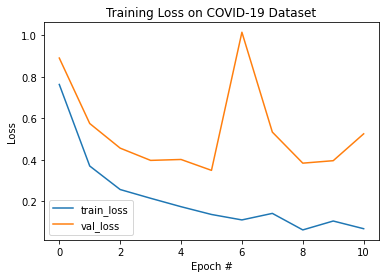

In [ ]:
H = HX
N = len(H.history["accuracy"])
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("/content/drive/My Drive/Colab Notebooks/Covid_19_DenseNet121/DenseNet121_final_model_Training_Loss.png", bbox_inches='tight')

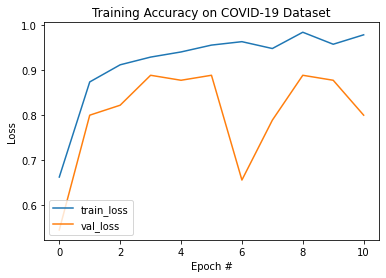

In [ ]:
H = HX
N = len(H.history["accuracy"])
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_loss")
plt.title("Training Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('/content/drive/My Drive/Colab Notebooks/Covid_19_DenseNet121/DenseNet121_final_model_Training_accuracy.png', bbox_inches='tight')

In [ ]:
modelX.save("/content/drive/My Drive/Colab Notebooks/Covid_19_DenseNet121_final_model.h5")